## Creación de base de datos y tabla
Se crea una función y una clase para crear una base de datos llamada Pragma y una tabla llamada COMPRAS.
Aquí se va a almacenar la información

In [1]:
from sqlalchemy import create_engine, Column, Integer, String, Date, UniqueConstraint
from sqlalchemy.ext.declarative import declarative_base


# Creamos una clase llamada "MyTable" que hereda los atributos de la clase declarative_base.
Base = declarative_base()
# Esta clase tiene una tabla llamada "compras" con los atributos "id", "id_usuario", "fecha" y "precio".
class MyTable(Base):
    __tablename__ = "COMPRAS"
    id = Column(Integer, primary_key=True, autoincrement=True)
    id_usuario = Column(Integer)
    fecha = Column(Date)
    precio = Column(Integer)
    UniqueConstraint(fecha, precio, id_usuario) # Validar constraint, truncar tabla


def crear_base_de_datos(engine):
    # Finalmente, utilizamos el método "create_all" para crear la tabla "compras" en la base de datos "Pragma.db".
    Base.metadata.create_all(engine)



C:\Users\luis_\AppData\Local\Temp\ipykernel_19452\3415400739.py:6: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


## Lectura de archivos y llenado de base de datos
Aquí se crean las funciones que permiten leer los archivos csv, procesarlos y enviarlos a la base de datos Pragma.
También se creó una función que permite imprimir las estadísticas en ejecución

In [2]:
import csv
import pandas as pd
import os
from sqlalchemy import create_engine

# Función para imprimir estadísticas
def mostrar_stadisticas(estadisticas: dict):
    """Imprime en pantalla las estadísticas actuales de los registros que han sido insertados en la base de datos.
    En particular tiene en cuenta los valores mínimo, máximo, promedio y número de registros de la columna precio de la tabla COMPRAS.

    Args:
        estadisticas (dict): diccionario que contiene las estadísticas
    """
    print(
        "Estadísticas: N° de registros: {}, Promedio: {}, Mínimo: {}, Máximo: {}".format(
            estadisticas["registros"],
            estadisticas["promedio"],
            estadisticas["minimo"],
            estadisticas["maximo"],
        )
    )


def extraer_datos_de_csv(archivo_csv):
    """Permite extraer la información contenida dentro del archivo csv pasado como argumento.
    Luego, da formato de float a la columna price y da formato de int a la columna user_id del archivo csv.
    En caso de encontrar un valor vacio en la columna price, la función asigna None a dicho valor.

    Args:
        archivo_csv (.csv): archivo csv que contiene la información

    Returns:
        df (pd.Dataframe): Devolvemos los datos extraídos en un Dataframe de Pandas
    """
    # Listas para almacenar los datos
    fechas = []
    precios = []
    ids = []
    # Función para convertir el precio a entero si no está vacío
    f_casting_precios = lambda x: int(x) if len(x) > 0 else None
    # Ruta del archivo CSV
    ruta = "Archivos/" + archivo_csv
    # Abrimos el archivo CSV
    with open(ruta, "r") as archivo:
        # Leemos el archivo con un lector de CSV
        lector = csv.reader(archivo, delimiter=",")
        # Ignoramos la cabecera
        next(lector)
        # Recorremos las líneas del archivo
        for linea in lector:
            # Añadimos fecha
            fechas.append(linea[0])
            # Convertimos el precio a entero si no está vacío
            precios.append(f_casting_precios(linea[1]))
            # Convertimos el id a entero
            ids.append(int(linea[2]))
    
    # Cargar CSV formateado a un dataframe de pandas
    diccionario = dict(fecha=fechas, precio=precios, id_usuario=ids)
    df = pd.DataFrame(diccionario)
    
    # Devolvemos los datos extraídos en un Dataframe de Pandas
    return df


def enviar_a_sql(engine, df, batch_size, estadisticas):
    """Toma un Dataframe de pandas (df) y lo envía a la base de datos pasada como argumento en la variable engine,
    en baches del tamaño batch_size y guarda el promedio, mínimo, máximo de la columna precios en la variable estadisticas.

    Args:
        engine (sqlalchemy.engine.base.Engine): controlador de base de datos
        df (pd.Dataframe): Dataframe con el conjunto de información organizada
        batch_size (int): Tamaño del bache de datos a ingestar
        estadisticas (dict): diccionario que contiene las estadisticas
    """

    # Función para calcular el promedio acumulado
    calc_cum_promedio = lambda x: x["suma_acumulada"] / x["registros_no_nulos"]
    # Función para calcular el mínimo acumulado
    calc_cum_min = (
        lambda anterior_min, min_: min_ if min_ < anterior_min else anterior_min
    )
    # Función para calcular el máximo acumulado
    calc_cum_max = (
        lambda anterior_max, max_: max_ if max_ > anterior_max else anterior_max
    )

    # Iterar sobre el dataframe por lotes (batches)
    batch_count = 1
    for i in range(0, len(df), batch_size):
        # Extraer el lote de datos
        batch = df[i : i + batch_size]
        # Escribir el lote en la base de datos SQL
        try:
            batch.to_sql("compras", con=engine, if_exists="append", index=False)
            print("Cargue exitoso del lote Nº", batch_count)
            batch_count += 1

            # Actualizar estadisticas
            estadisticas["registros"] += batch.fecha.count()
            estadisticas["suma_acumulada"] += batch.precio.sum()
            estadisticas["registros_no_nulos"] += batch.precio.count()
            estadisticas["promedio"] = calc_cum_promedio(estadisticas)
            estadisticas["minimo"] = calc_cum_min(
                estadisticas["minimo"], batch.precio.min()
            )
            estadisticas["maximo"] = calc_cum_max(
                estadisticas["maximo"], batch.precio.max()
            )
            # Imprimir estadisticas
            mostrar_stadisticas(estadisticas)

        except Exception as e:
            print("Error al guardar la información en la base de datos:")
            print(e.args)

## Comprobación de resultados
- Comprobación de estadísticas en ejecución

In [3]:
# Creamos una instancia de motor de base de datos llamada "engine" para conectarnos a la base de datos "Pragma.db".
engine = create_engine("sqlite:///Pragma.db")
crear_base_de_datos(engine)

# Listamos los archivos contenidos en la carpeta Archivos
lista_de_archivos = os.listdir("Archivos/")

# Dejamos en una variable aparte el archivo validation.csv
archivo_de_validacion = lista_de_archivos.pop()

# Inicializamos las estadísticas
estadisticas = {
    "registros_no_nulos": 0,
    "suma_acumulada": 0,
    "registros": 0,
    "promedio": None,
    "minimo": 100,
    "maximo": 0,
}

# Recorremos la lista que contiene los archivos csv a procesar
for archivo_csv in lista_de_archivos:
    print("Cargando información de archivo", archivo_csv)
    fechas, precios, ids = extraer_datos_de_csv(archivo_csv)

    # Cargar CSV formateado a un dataframe de pandas
    diccionario = dict(fecha=fechas, precio=precios, id_usuario=ids)
    df = pd.DataFrame(diccionario)

    # Ajustar el tamaño del lote (batch size)
    batch_size = 10
    # Enviar el dataframe por lotes a la base de datos
    enviar_a_sql(engine, df, batch_size, estadisticas)
    # Imprime un salto de línea
    print("\n")

Cargando información de archivo 2012-1.csv
Cargue exitoso del lote Nº 1
Estadísticas: N° de registros: 5, Promedio: 47.0, Mínimo: 14.0, Máximo: 87.0
Cargue exitoso del lote Nº 2
Estadísticas: N° de registros: 10, Promedio: 63.0, Mínimo: 14.0, Máximo: 97.0
Cargue exitoso del lote Nº 3
Estadísticas: N° de registros: 15, Promedio: 58.357142857142854, Mínimo: 14.0, Máximo: 97.0
Cargue exitoso del lote Nº 4
Estadísticas: N° de registros: 20, Promedio: 58.1578947368421, Mínimo: 14.0, Máximo: 97.0
Cargue exitoso del lote Nº 5
Estadísticas: N° de registros: 22, Promedio: 59.65, Mínimo: 14.0, Máximo: 97.0


Cargando información de archivo 2012-2.csv
Cargue exitoso del lote Nº 1
Estadísticas: N° de registros: 27, Promedio: 60.04, Mínimo: 14.0, Máximo: 100
Cargue exitoso del lote Nº 2
Estadísticas: N° de registros: 32, Promedio: 60.36666666666667, Mínimo: 14.0, Máximo: 100
Cargue exitoso del lote Nº 3
Estadísticas: N° de registros: 37, Promedio: 60.51428571428571, Mínimo: 12, Máximo: 100
Cargue e

## Comprobación de resultados
- Realiza una consulta en la base de datos del: recuento total de
filas, valor promedio, valor mínimo y valor máximo para el campo
“price”.

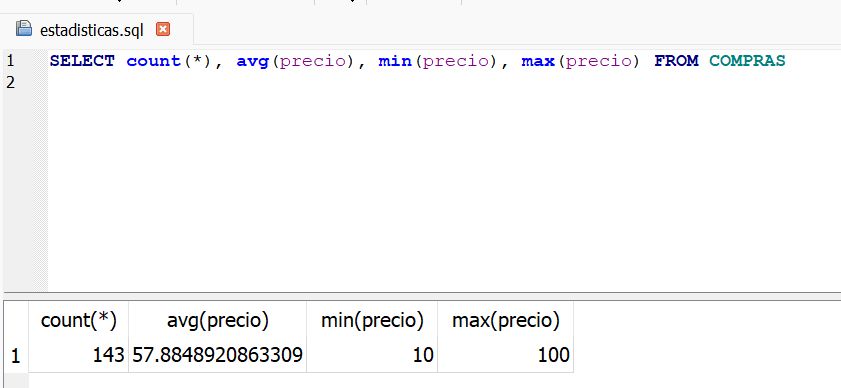

## Comprobación de resultados
- Ejecuta el archivo “validation.csv” a través de todo el pipeline y
muestra el valor de las estadísticas en ejecución.

In [4]:
# Extraemos la información del archivo validation.csv
print("Cargando información de archivo", archivo_de_validacion)
df = extraer_datos_de_csv(archivo_de_validacion)

# Ajustar el tamaño del lote (batch size)
batch_size = 5

# Enviar el dataframe por lotes a la base de datos
enviar_a_sql(engine, df, batch_size, estadisticas)
# Imprime un salto de línea
print("\n")

Cargando información de archivo validation.csv
Cargue exitoso del lote Nº 1
Estadísticas: N° de registros: 148, Promedio: 57.076388888888886, Mínimo: 10, Máximo: 100
Cargue exitoso del lote Nº 2
Estadísticas: N° de registros: 151, Promedio: 57.006802721088434, Mínimo: 10, Máximo: 100




## Comprobación de resultados
- Realice una nueva consulta en la base de datos después de cargar
“validation.csv”, para observar cómo cambiaron los valores del:
recuento total de filas, valor promedio, valor mínimo y valor máximo
para el campo “price”.

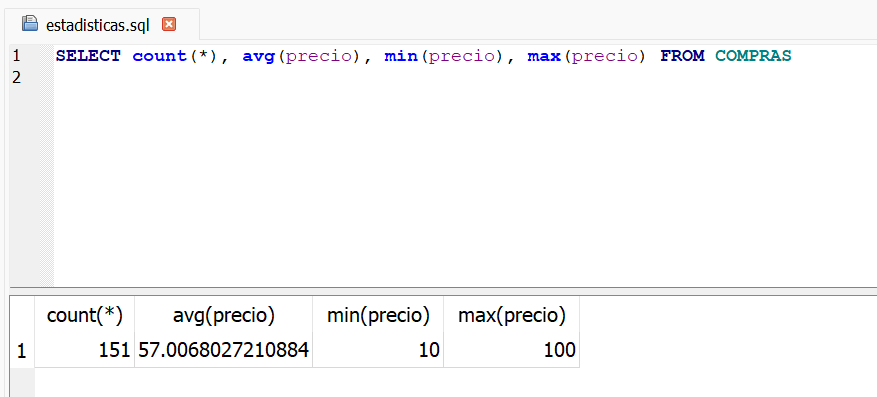